In [1]:
%cd /kaggle/working

/kaggle/working


In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

# CV
from PIL import Image

import pytorch_lightning as pl
from torchmetrics import MetricCollection, MeanSquaredError
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage
from utils.lightning_utils import MyLightningDataModule
from utils.torch_models import Conv1dBnRelu

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-09-25 06:52:23.402694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-09-25 06:52:23.402869: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib

In [3]:
config = f"""
execution:
    exp_id: exp_020
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

# fix seed
seed = CFG["seed"]
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
class ZzzMetaDataset(Dataset):
    def __init__(self, dfs: list[pd.DataFrame], mode: str, features: Features):
        self.dfs = dfs
        self.mode = mode
        self.features = features

    def __len__(self):
        return len(self.dfs)

    def __getitem__(self, index):
        df = self.dfs[index]

        feats = df[self.features.all_features()].values.astype(np.float32)

        if self.mode == "train":
            targets = df["target"].values.astype(np.float32)
            return feats, targets
        else:
            return feats

In [5]:
class MetaLSTMModule(pl.LightningModule):
    def __init__(self, dim_impput: int, loss_fn=nn.CrossEntropyLoss(), lr=0.001, weight_decay=0):
        super().__init__()
        
        self.meta_mlp = nn.Sequential(
            nn.Linear(dim_impput, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 256),
        )
        self.lstm = nn.LSTM(256, 256, num_layers=2,
                            dropout=0, bidirectional=True, batch_first=True)

        self.head = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1),
        )
        self.loss_fn = loss_fn
        self.lr = lr
        self.weight_decay = weight_decay

        self.train_metrics = MetricCollection([], prefix="")
        self.valid_metrics = MetricCollection([], prefix="val_")
        
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, feat):
        bs = feat.shape[0]
        slen = feat.shape[1]
        
        feat = feat.view(bs * slen, -1)
        feat = self.meta_mlp(feat)
        feat = feat.view(bs, slen, -1)

        feat, _ = self.lstm(feat)
        feat = feat.contiguous().view(bs * slen, -1)
        logits = self.head(feat)
        logits = logits.view(bs, slen)
        return logits

    def training_step(self, batch, batch_idx):
        X, y = batch
        preds = self.forward(X)

        loss = self.loss_fn(preds, y)

        self.train_metrics(preds, y)
        self.log("loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True,)
        self.log_dict(self.train_metrics, prog_bar=True, logger=True, on_epoch=True, on_step=True,)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        X, y = batch
        preds = self.forward(X)
        
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(y)

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_step_outputs)
        labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        loss = self.loss_fn(preds, labels)

        self.valid_metrics(preds, labels)
        self.log("val_loss", loss, prog_bar=False, logger=True, on_epoch=True, on_step=False,)
        self.log_dict(self.valid_metrics, prog_bar=False, logger=True, on_epoch=True, on_step=False,)

        # ログをprint
        self.print_metric(preds, labels, "valid")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)
        return {"optimizer": optimizer, 
                "lr_scheduler": scheduler, 
                "monitor": "val_loss"}
                
    def print_metric(self, y_hat, y, train_or_valid="train"):
        """
        ログをprintする。次のepochが終わると上書きされてしまうので。
        TODO: たぶんもっとマシな方法があるので探す。
        """
        if train_or_valid == "train":
            metrics = self.train_metrics
        else:
            metrics = self.valid_metrics
        loss = self.loss_fn(y_hat, y)

        print(f"[epoch {self.trainer.current_epoch}] {train_or_valid}: ", end="")
        print(f"{type(self.loss_fn).__name__}={loss:.4f}", end=", ")
        for name in metrics:
            v = metrics[name](y_hat, y)
            print(f"{name}={v:.4f}", end=", ")
        print()

In [6]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    train["total_seconds"] = (total_seconds + train.index * 5) % (24 * 60 * 60) # [sec]
    features.add_num_feature("total_seconds")    

    columns = ["anglez", "enmo"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["anglez_mean"] = train["total_seconds"].map(gb["anglez_mean"])
    train["enmo_mean"] = train["total_seconds"].map(gb["enmo_mean"])
    features.add_num_features(gb.columns.tolist())
    columns += gb.columns.tolist()

    # rolling
    dts = [10, 50, 100, 1000]
    shift_features_dic = {}
    for dt in dts:       
        shift_features = []

        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)
        shift_features += f_names

        shift_features_dic[dt] = shift_features

    # 一定stepで集約
    series_id = train["series_id"].values[0]
    agg_freq = CFG["feature"]["agg_freq"]
    columns = features.all_features() + ["target", "step"]
    train = train[columns].groupby(train["step"].values // agg_freq).mean()
    train["series_id"] = series_id
    train["target"] = train["target"].round().astype(int)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return train, features

In [7]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        results = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
    dfs, features = zip(*results)
    train = pd.concat(dfs)
    features = features[0]
else:
    dfs = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        dfs.append(train)
    train = pd.concat(dfs)
    features = features[0]

train.head()

100%|██████████| 277/277 [03:22<00:00,  1.37it/s]


,anglez_mean,anglez_mean_rolling_max_10,anglez_mean_rolling_max_100,anglez_mean_rolling_max_1000,anglez_mean_rolling_max_50,anglez_mean_rolling_mean_10,anglez_mean_rolling_mean_100,anglez_mean_rolling_mean_1000,anglez_mean_rolling_mean_50,anglez_mean_rolling_median_10,...,enmo_rolling_square_mean_1000,enmo_rolling_square_mean_50,enmo_rolling_std_10,enmo_rolling_std_100,enmo_rolling_std_1000,enmo_rolling_std_50,total_seconds,target,step,series_id
0,-21.856409,-16.917899,NaN,NaN,NaN,-21.959140,NaN,NaN,NaN,-21.683537,...,NaN,NaN,0.000000,NaN,NaN,NaN,40557.5,1,11.5,af91d9a50547
1,-18.678552,-14.409011,NaN,NaN,-13.496142,-18.425795,NaN,NaN,-19.711186,-18.656307,...,NaN,0.000000,0.000000,NaN,NaN,0.000000,40677.5,1,35.5,af91d9a50547
2,-21.056643,-17.015743,-13.496142,NaN,-14.404611,-21.581524,-21.621266,NaN,-21.646659,-21.564984,...,NaN,0.000003,0.000000,0.00146,NaN,0.001634,40797.5,1,59.5,af91d9a50547
3,-24.669419,-20.743087,-14.039940,NaN,-16.262264,-24.374674,-22.746637,NaN,-23.424783,-24.352811,...,NaN,0.000004,0.001924,0.00146,NaN,0.002064,40917.5,1,83.5,af91d9a50547
4,-24.068844,-18.300946,-13.864842,NaN,-15.698003,-23.899454,-23.069201,NaN,-24.021655,-23.948038,...,NaN,0.000001,0.000000,0.00146,NaN,0.000604,41037.5,1,107.5,af91d9a50547


In [8]:
print(len(features.all_features()))

99


In [9]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train = train.merge(cv_split, on=["series_id"], how="left")
display(train.head(5))
train.shape

,anglez_mean,anglez_mean_rolling_max_10,anglez_mean_rolling_max_100,anglez_mean_rolling_max_1000,anglez_mean_rolling_max_50,anglez_mean_rolling_mean_10,anglez_mean_rolling_mean_100,anglez_mean_rolling_mean_1000,anglez_mean_rolling_mean_50,anglez_mean_rolling_median_10,...,enmo_rolling_square_mean_50,enmo_rolling_std_10,enmo_rolling_std_100,enmo_rolling_std_1000,enmo_rolling_std_50,total_seconds,target,step,series_id,fold
0,-21.856409,-16.917899,NaN,NaN,NaN,-21.959140,NaN,NaN,NaN,-21.683537,...,NaN,0.000000,NaN,NaN,NaN,40557.5,1,11.5,af91d9a50547,3
1,-18.678552,-14.409011,NaN,NaN,-13.496142,-18.425795,NaN,NaN,-19.711186,-18.656307,...,0.000000,0.000000,NaN,NaN,0.000000,40677.5,1,35.5,af91d9a50547,3
2,-21.056643,-17.015743,-13.496142,NaN,-14.404611,-21.581524,-21.621266,NaN,-21.646659,-21.564984,...,0.000003,0.000000,0.00146,NaN,0.001634,40797.5,1,59.5,af91d9a50547,3
3,-24.669419,-20.743087,-14.039940,NaN,-16.262264,-24.374674,-22.746637,NaN,-23.424783,-24.352811,...,0.000004,0.001924,0.00146,NaN,0.002064,40917.5,1,83.5,af91d9a50547,3
4,-24.068844,-18.300946,-13.864842,NaN,-15.698003,-23.899454,-23.069201,NaN,-24.021655,-23.948038,...,0.000001,0.000000,0.00146,NaN,0.000604,41037.5,1,107.5,af91d9a50547,3


(5331163, 103)

In [10]:
train.fillna(-100, inplace=True)

In [11]:
SEQ_LEN = 300

# SEQ_LEN ごとに分割
dfs = []
for series_id, df in tqdm(train.groupby("series_id")):
    df = df.sort_values("step")

    for start in range(0, len(df), SEQ_LEN // 2):
        end = start + SEQ_LEN
        if end > len(df):
            end = len(df)
            start = end - SEQ_LEN
            assert start >= 0
        dfs.append(df.iloc[start: end])
gc.collect()

dataset_oof = ZzzMetaDataset(dfs, 'train', features)
feats, targets = dataset_oof[0]
feats.shape, targets.shape

100%|██████████| 277/277 [00:02<00:00, 96.31it/s] 


((300, 99), (300,))

In [12]:
!rm -r logs

In [13]:
fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzMetaDataset(train_dfs, mode="train", features=features)
    valid_dataset = ZzzMetaDataset(valid_dfs, mode="train", features=features)
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=256)

    # モデル
    model = MetaLSTMModule(lr=0.0001, dim_impput=len(features.all_features()), loss_fn=nn.BCEWithLogitsLoss())
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=5,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        )
    trainer.fit(model, datamodule=data_module)

    # 推論
    preds = []
    model = MetaLSTMModule.load_from_checkpoint(f"logs/best_model_fold{fold}.ckpt", dim_impput=len(features.all_features()), lr=0.001, loss_fn=nn.BCEWithLogitsLoss()).to("cuda")
    model.eval()
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = F.sigmoid(model(X.to("cuda"))).detach().cpu().numpy()
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df["oof"] = pred
        df = df.drop(columns=features.all_features())
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df)
train = pd.concat(fold_oof_dfs)

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6683, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.3004, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.2389, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.2007, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1783, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1542, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1821, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1387, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1248, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1234, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1452, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: BCEWithLogitsLoss=0.1216, 


Validation: 0it [00:00, ?it/s]

[epoch 11] valid: BCEWithLogitsLoss=0.1158, 


Validation: 0it [00:00, ?it/s]

[epoch 12] valid: BCEWithLogitsLoss=0.1105, 


Validation: 0it [00:00, ?it/s]

[epoch 13] valid: BCEWithLogitsLoss=0.1071, 


Validation: 0it [00:00, ?it/s]

[epoch 14] valid: BCEWithLogitsLoss=0.1156, 


Validation: 0it [00:00, ?it/s]

[epoch 15] valid: BCEWithLogitsLoss=0.1086, 


Validation: 0it [00:00, ?it/s]

[epoch 16] valid: BCEWithLogitsLoss=0.1105, 


Validation: 0it [00:00, ?it/s]

[epoch 17] valid: BCEWithLogitsLoss=0.1039, 


Validation: 0it [00:00, ?it/s]

[epoch 18] valid: BCEWithLogitsLoss=0.1080, 


Validation: 0it [00:00, ?it/s]

[epoch 19] valid: BCEWithLogitsLoss=0.1054, 


Validation: 0it [00:00, ?it/s]

[epoch 20] valid: BCEWithLogitsLoss=0.1533, 


Validation: 0it [00:00, ?it/s]

[epoch 21] valid: BCEWithLogitsLoss=0.1218, 
Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

[epoch 22] valid: BCEWithLogitsLoss=0.1112, 
== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7116, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.3193, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.2694, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.2144, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1839, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1559, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1291, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1200, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1316, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1095, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1057, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: BCEWithLogitsLoss=0.0989, 


Validation: 0it [00:00, ?it/s]

[epoch 11] valid: BCEWithLogitsLoss=0.0989, 


Validation: 0it [00:00, ?it/s]

[epoch 12] valid: BCEWithLogitsLoss=0.0934, 


Validation: 0it [00:00, ?it/s]

[epoch 13] valid: BCEWithLogitsLoss=0.0889, 


Validation: 0it [00:00, ?it/s]

[epoch 14] valid: BCEWithLogitsLoss=0.0858, 


Validation: 0it [00:00, ?it/s]

[epoch 15] valid: BCEWithLogitsLoss=0.0934, 


Validation: 0it [00:00, ?it/s]

[epoch 16] valid: BCEWithLogitsLoss=0.1225, 


Validation: 0it [00:00, ?it/s]

[epoch 17] valid: BCEWithLogitsLoss=0.1054, 


Validation: 0it [00:00, ?it/s]

[epoch 18] valid: BCEWithLogitsLoss=0.0829, 


Validation: 0it [00:00, ?it/s]

[epoch 19] valid: BCEWithLogitsLoss=0.0812, 


Validation: 0it [00:00, ?it/s]

[epoch 20] valid: BCEWithLogitsLoss=0.0823, 


Validation: 0it [00:00, ?it/s]

[epoch 21] valid: BCEWithLogitsLoss=0.1031, 


Validation: 0it [00:00, ?it/s]

[epoch 22] valid: BCEWithLogitsLoss=0.0793, 


Validation: 0it [00:00, ?it/s]

[epoch 23] valid: BCEWithLogitsLoss=0.0854, 


Validation: 0it [00:00, ?it/s]

[epoch 24] valid: BCEWithLogitsLoss=0.0792, 


Validation: 0it [00:00, ?it/s]

[epoch 25] valid: BCEWithLogitsLoss=0.0878, 


Validation: 0it [00:00, ?it/s]

[epoch 26] valid: BCEWithLogitsLoss=0.0791, 


Validation: 0it [00:00, ?it/s]

[epoch 27] valid: BCEWithLogitsLoss=0.0797, 


Validation: 0it [00:00, ?it/s]

[epoch 28] valid: BCEWithLogitsLoss=0.0763, 


Validation: 0it [00:00, ?it/s]

[epoch 29] valid: BCEWithLogitsLoss=0.0803, 


Validation: 0it [00:00, ?it/s]

[epoch 30] valid: BCEWithLogitsLoss=0.0733, 


Validation: 0it [00:00, ?it/s]

[epoch 31] valid: BCEWithLogitsLoss=0.0740, 


Validation: 0it [00:00, ?it/s]

[epoch 32] valid: BCEWithLogitsLoss=0.0723, 


Validation: 0it [00:00, ?it/s]

[epoch 33] valid: BCEWithLogitsLoss=0.0758, 


Validation: 0it [00:00, ?it/s]

[epoch 34] valid: BCEWithLogitsLoss=0.0733, 


Validation: 0it [00:00, ?it/s]

[epoch 35] valid: BCEWithLogitsLoss=0.0729, 


Validation: 0it [00:00, ?it/s]

[epoch 36] valid: BCEWithLogitsLoss=0.0741, 
Epoch 00037: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

[epoch 37] valid: BCEWithLogitsLoss=0.0709, 


Validation: 0it [00:00, ?it/s]

[epoch 38] valid: BCEWithLogitsLoss=0.0700, 


Validation: 0it [00:00, ?it/s]

[epoch 39] valid: BCEWithLogitsLoss=0.0708, 


Validation: 0it [00:00, ?it/s]

[epoch 40] valid: BCEWithLogitsLoss=0.0701, 


Validation: 0it [00:00, ?it/s]

[epoch 41] valid: BCEWithLogitsLoss=0.0703, 


Validation: 0it [00:00, ?it/s]

[epoch 42] valid: BCEWithLogitsLoss=0.0704, 
Epoch 00043: reducing learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

[epoch 43] valid: BCEWithLogitsLoss=0.0708, 
== fold 2 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7113, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.2890, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.2713, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.2032, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1647, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1793, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1437, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1429, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1388, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1325, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1154, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: BCEWithLogitsLoss=0.1136, 


Validation: 0it [00:00, ?it/s]

[epoch 11] valid: BCEWithLogitsLoss=0.1069, 


Validation: 0it [00:00, ?it/s]

[epoch 12] valid: BCEWithLogitsLoss=0.1035, 


Validation: 0it [00:00, ?it/s]

[epoch 13] valid: BCEWithLogitsLoss=0.1234, 


Validation: 0it [00:00, ?it/s]

[epoch 14] valid: BCEWithLogitsLoss=0.0964, 


Validation: 0it [00:00, ?it/s]

[epoch 15] valid: BCEWithLogitsLoss=0.0955, 


Validation: 0it [00:00, ?it/s]

[epoch 16] valid: BCEWithLogitsLoss=0.0933, 


Validation: 0it [00:00, ?it/s]

[epoch 17] valid: BCEWithLogitsLoss=0.1056, 


Validation: 0it [00:00, ?it/s]

[epoch 18] valid: BCEWithLogitsLoss=0.0959, 


Validation: 0it [00:00, ?it/s]

[epoch 19] valid: BCEWithLogitsLoss=0.0930, 


Validation: 0it [00:00, ?it/s]

[epoch 20] valid: BCEWithLogitsLoss=0.0895, 


Validation: 0it [00:00, ?it/s]

[epoch 21] valid: BCEWithLogitsLoss=0.0999, 


Validation: 0it [00:00, ?it/s]

[epoch 22] valid: BCEWithLogitsLoss=0.0855, 


Validation: 0it [00:00, ?it/s]

[epoch 23] valid: BCEWithLogitsLoss=0.0847, 


Validation: 0it [00:00, ?it/s]

[epoch 24] valid: BCEWithLogitsLoss=0.0932, 


Validation: 0it [00:00, ?it/s]

[epoch 25] valid: BCEWithLogitsLoss=0.0839, 


Validation: 0it [00:00, ?it/s]

[epoch 26] valid: BCEWithLogitsLoss=0.0846, 


Validation: 0it [00:00, ?it/s]

[epoch 27] valid: BCEWithLogitsLoss=0.0940, 


Validation: 0it [00:00, ?it/s]

[epoch 28] valid: BCEWithLogitsLoss=0.0895, 


Validation: 0it [00:00, ?it/s]

[epoch 29] valid: BCEWithLogitsLoss=0.0876, 
Epoch 00030: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

[epoch 30] valid: BCEWithLogitsLoss=0.0840, 
== fold 3 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6764, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.2911, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.2400, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.1904, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1816, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1413, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1337, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1281, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1663, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1392, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1168, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: BCEWithLogitsLoss=0.1093, 


Validation: 0it [00:00, ?it/s]

[epoch 11] valid: BCEWithLogitsLoss=0.1148, 


Validation: 0it [00:00, ?it/s]

[epoch 12] valid: BCEWithLogitsLoss=0.1236, 


Validation: 0it [00:00, ?it/s]

[epoch 13] valid: BCEWithLogitsLoss=0.1150, 


Validation: 0it [00:00, ?it/s]

[epoch 14] valid: BCEWithLogitsLoss=0.1035, 


Validation: 0it [00:00, ?it/s]

[epoch 15] valid: BCEWithLogitsLoss=0.1152, 


Validation: 0it [00:00, ?it/s]

[epoch 16] valid: BCEWithLogitsLoss=0.1013, 


Validation: 0it [00:00, ?it/s]

[epoch 17] valid: BCEWithLogitsLoss=0.0980, 


Validation: 0it [00:00, ?it/s]

[epoch 18] valid: BCEWithLogitsLoss=0.0928, 


Validation: 0it [00:00, ?it/s]

[epoch 19] valid: BCEWithLogitsLoss=0.1056, 


Validation: 0it [00:00, ?it/s]

[epoch 20] valid: BCEWithLogitsLoss=0.1469, 


Validation: 0it [00:00, ?it/s]

[epoch 21] valid: BCEWithLogitsLoss=0.0952, 


Validation: 0it [00:00, ?it/s]

[epoch 22] valid: BCEWithLogitsLoss=0.0970, 
Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

[epoch 23] valid: BCEWithLogitsLoss=0.0907, 


Validation: 0it [00:00, ?it/s]

[epoch 24] valid: BCEWithLogitsLoss=0.0907, 


Validation: 0it [00:00, ?it/s]

[epoch 25] valid: BCEWithLogitsLoss=0.0904, 


Validation: 0it [00:00, ?it/s]

[epoch 26] valid: BCEWithLogitsLoss=0.0899, 


Validation: 0it [00:00, ?it/s]

[epoch 27] valid: BCEWithLogitsLoss=0.0893, 


Validation: 0it [00:00, ?it/s]

[epoch 28] valid: BCEWithLogitsLoss=0.0898, 


Validation: 0it [00:00, ?it/s]

[epoch 29] valid: BCEWithLogitsLoss=0.0900, 


Validation: 0it [00:00, ?it/s]

[epoch 30] valid: BCEWithLogitsLoss=0.0900, 


Validation: 0it [00:00, ?it/s]

[epoch 31] valid: BCEWithLogitsLoss=0.0898, 
Epoch 00032: reducing learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

[epoch 32] valid: BCEWithLogitsLoss=0.0889, 


Validation: 0it [00:00, ?it/s]

[epoch 33] valid: BCEWithLogitsLoss=0.0890, 


Validation: 0it [00:00, ?it/s]

[epoch 34] valid: BCEWithLogitsLoss=0.0889, 


Validation: 0it [00:00, ?it/s]

[epoch 35] valid: BCEWithLogitsLoss=0.0890, 


Validation: 0it [00:00, ?it/s]

[epoch 36] valid: BCEWithLogitsLoss=0.0890, 


Validation: 0it [00:00, ?it/s]

[epoch 37] valid: BCEWithLogitsLoss=0.0890, 


Validation: 0it [00:00, ?it/s]

[epoch 38] valid: BCEWithLogitsLoss=0.0888, 


Validation: 0it [00:00, ?it/s]

[epoch 39] valid: BCEWithLogitsLoss=0.0889, 


Validation: 0it [00:00, ?it/s]

[epoch 40] valid: BCEWithLogitsLoss=0.0887, 


Validation: 0it [00:00, ?it/s]

[epoch 41] valid: BCEWithLogitsLoss=0.0890, 


Validation: 0it [00:00, ?it/s]

[epoch 42] valid: BCEWithLogitsLoss=0.0895, 


Validation: 0it [00:00, ?it/s]

[epoch 43] valid: BCEWithLogitsLoss=0.0888, 


Validation: 0it [00:00, ?it/s]

[epoch 44] valid: BCEWithLogitsLoss=0.0888, 
Epoch 00045: reducing learning rate of group 0 to 1.0000e-07.


Validation: 0it [00:00, ?it/s]

[epoch 45] valid: BCEWithLogitsLoss=0.0888, 
== fold 4 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6654, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.2789, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.2103, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.1843, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.1596, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.1908, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: BCEWithLogitsLoss=0.1704, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: BCEWithLogitsLoss=0.1394, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: BCEWithLogitsLoss=0.1470, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: BCEWithLogitsLoss=0.1372, 


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: BCEWithLogitsLoss=0.1245, 


Validation: 0it [00:00, ?it/s]

[epoch 10] valid: BCEWithLogitsLoss=0.1345, 


Validation: 0it [00:00, ?it/s]

[epoch 11] valid: BCEWithLogitsLoss=0.1343, 


Validation: 0it [00:00, ?it/s]

[epoch 12] valid: BCEWithLogitsLoss=0.1159, 


Validation: 0it [00:00, ?it/s]

[epoch 13] valid: BCEWithLogitsLoss=0.1172, 


Validation: 0it [00:00, ?it/s]

[epoch 14] valid: BCEWithLogitsLoss=0.1128, 


Validation: 0it [00:00, ?it/s]

[epoch 15] valid: BCEWithLogitsLoss=0.1111, 


Validation: 0it [00:00, ?it/s]

[epoch 16] valid: BCEWithLogitsLoss=0.1145, 


Validation: 0it [00:00, ?it/s]

[epoch 17] valid: BCEWithLogitsLoss=0.1278, 


Validation: 0it [00:00, ?it/s]

[epoch 18] valid: BCEWithLogitsLoss=0.1140, 


Validation: 0it [00:00, ?it/s]

[epoch 19] valid: BCEWithLogitsLoss=0.1093, 


Validation: 0it [00:00, ?it/s]

[epoch 20] valid: BCEWithLogitsLoss=0.1047, 


Validation: 0it [00:00, ?it/s]

[epoch 21] valid: BCEWithLogitsLoss=0.1057, 


Validation: 0it [00:00, ?it/s]

[epoch 22] valid: BCEWithLogitsLoss=0.1317, 


Validation: 0it [00:00, ?it/s]

[epoch 23] valid: BCEWithLogitsLoss=0.1249, 


Validation: 0it [00:00, ?it/s]

[epoch 24] valid: BCEWithLogitsLoss=0.1057, 
Epoch 00025: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

[epoch 25] valid: BCEWithLogitsLoss=0.1029, 


Validation: 0it [00:00, ?it/s]

[epoch 26] valid: BCEWithLogitsLoss=0.1044, 


Validation: 0it [00:00, ?it/s]

[epoch 27] valid: BCEWithLogitsLoss=0.1037, 


Validation: 0it [00:00, ?it/s]

[epoch 28] valid: BCEWithLogitsLoss=0.1031, 


Validation: 0it [00:00, ?it/s]

[epoch 29] valid: BCEWithLogitsLoss=0.1025, 


Validation: 0it [00:00, ?it/s]

[epoch 30] valid: BCEWithLogitsLoss=0.1071, 


Validation: 0it [00:00, ?it/s]

[epoch 31] valid: BCEWithLogitsLoss=0.1028, 


Validation: 0it [00:00, ?it/s]

[epoch 32] valid: BCEWithLogitsLoss=0.1021, 


Validation: 0it [00:00, ?it/s]

[epoch 33] valid: BCEWithLogitsLoss=0.1020, 


Validation: 0it [00:00, ?it/s]

[epoch 34] valid: BCEWithLogitsLoss=0.1010, 


Validation: 0it [00:00, ?it/s]

[epoch 35] valid: BCEWithLogitsLoss=0.1014, 


Validation: 0it [00:00, ?it/s]

[epoch 36] valid: BCEWithLogitsLoss=0.1015, 


Validation: 0it [00:00, ?it/s]

[epoch 37] valid: BCEWithLogitsLoss=0.1022, 


Validation: 0it [00:00, ?it/s]

[epoch 38] valid: BCEWithLogitsLoss=0.1011, 
Epoch 00039: reducing learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

[epoch 39] valid: BCEWithLogitsLoss=0.1008, 


Validation: 0it [00:00, ?it/s]

[epoch 40] valid: BCEWithLogitsLoss=0.1003, 


Validation: 0it [00:00, ?it/s]

[epoch 41] valid: BCEWithLogitsLoss=0.1009, 


Validation: 0it [00:00, ?it/s]

[epoch 42] valid: BCEWithLogitsLoss=0.1016, 


Validation: 0it [00:00, ?it/s]

[epoch 43] valid: BCEWithLogitsLoss=0.1008, 


Validation: 0it [00:00, ?it/s]

[epoch 44] valid: BCEWithLogitsLoss=0.1016, 
Epoch 00045: reducing learning rate of group 0 to 1.0000e-07.


Validation: 0it [00:00, ?it/s]

[epoch 45] valid: BCEWithLogitsLoss=0.1009, 


  0%|          | 0/277 [00:00<?, ?it/s]

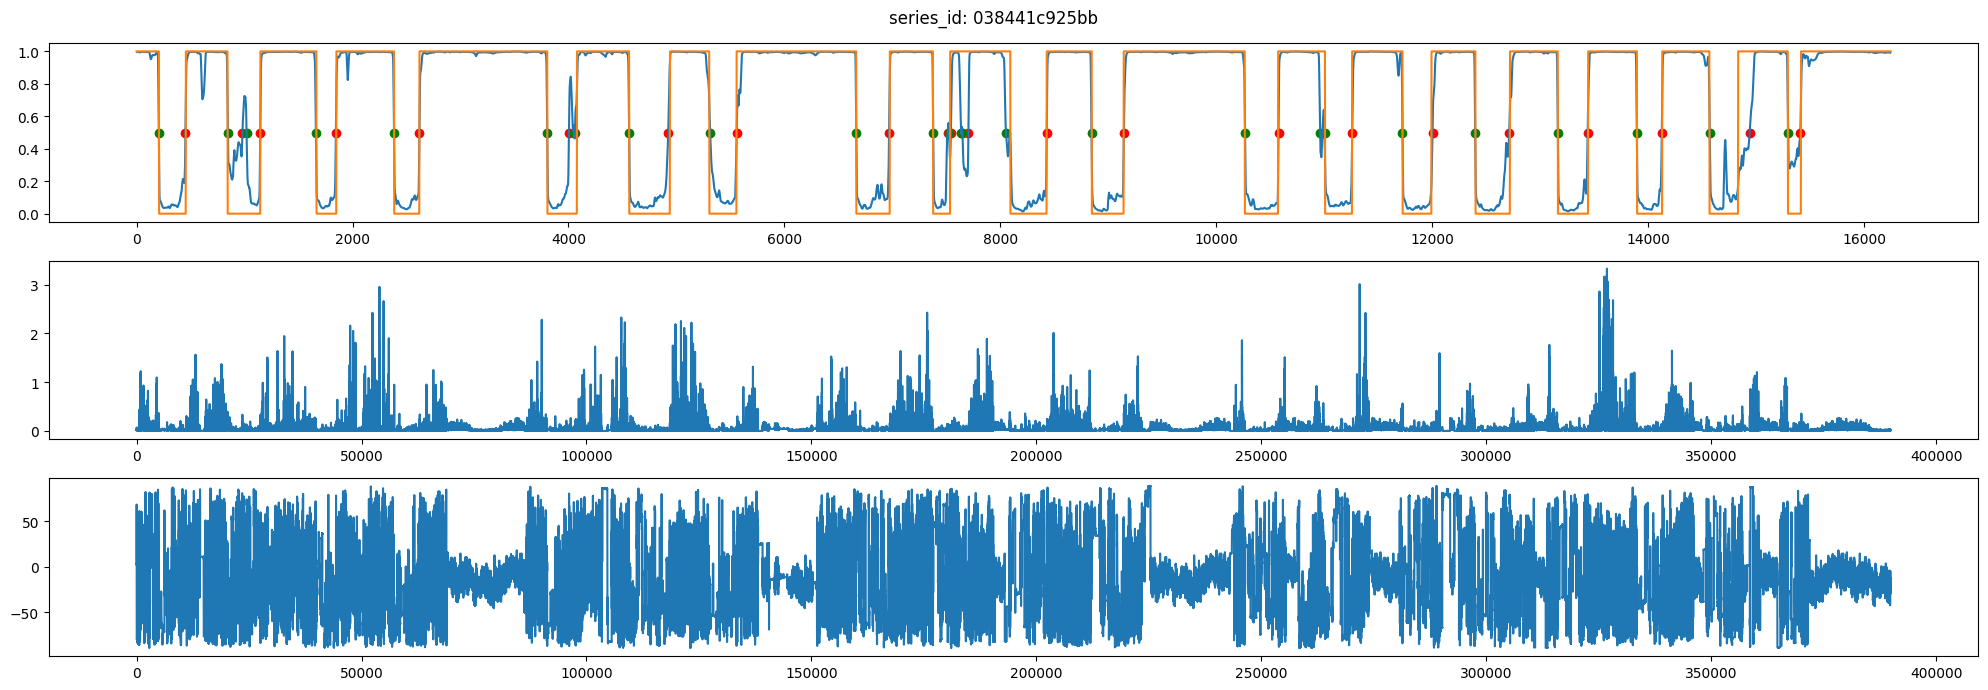

  0%|          | 1/277 [00:01<07:09,  1.56s/it]

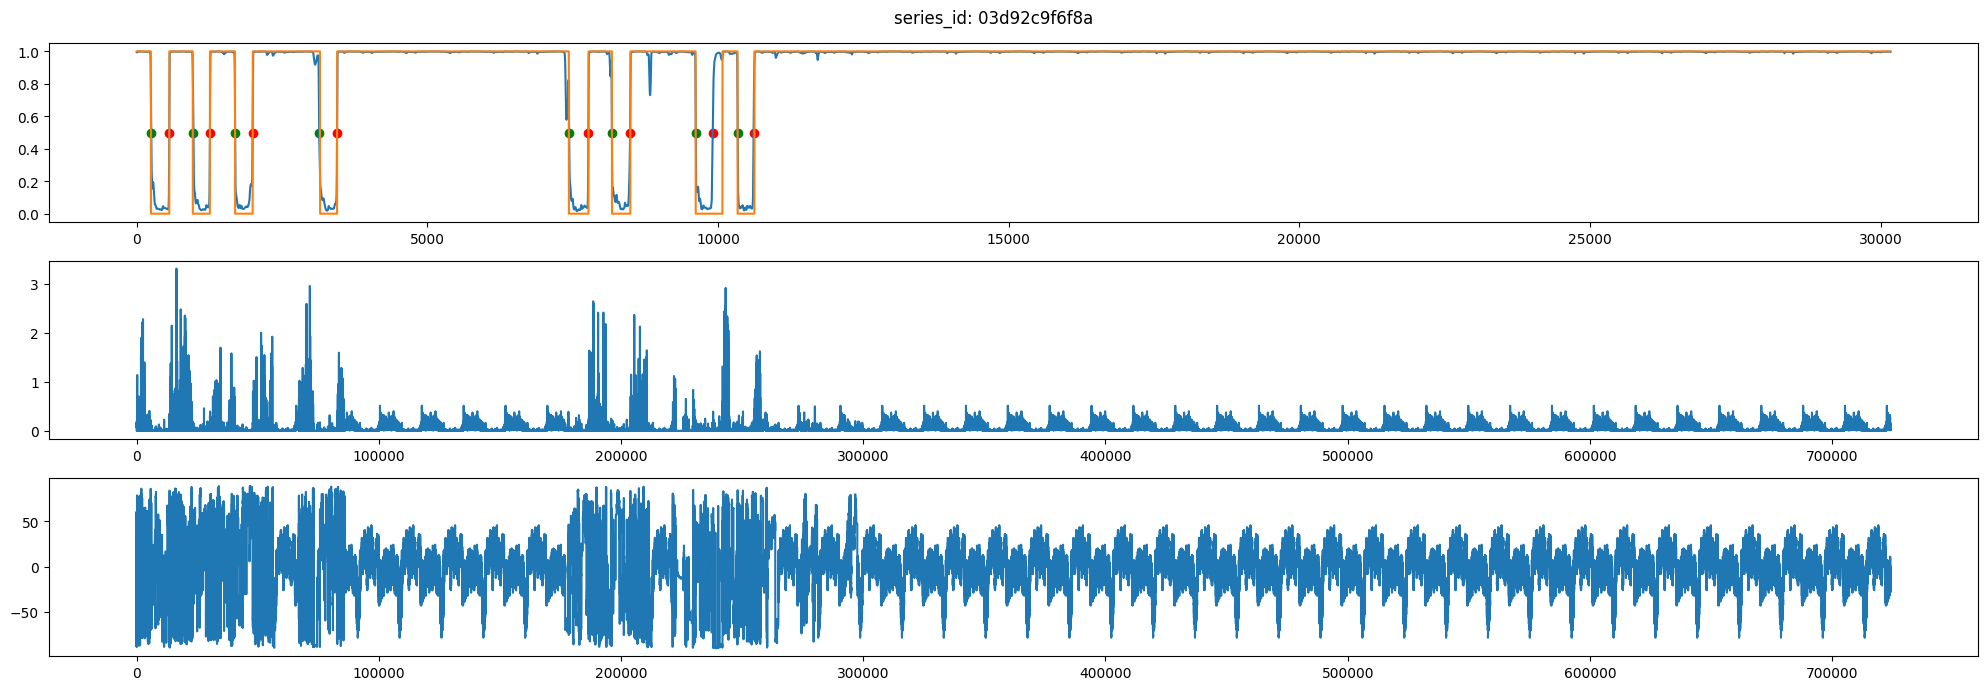

  1%|          | 2/277 [00:02<06:29,  1.42s/it]

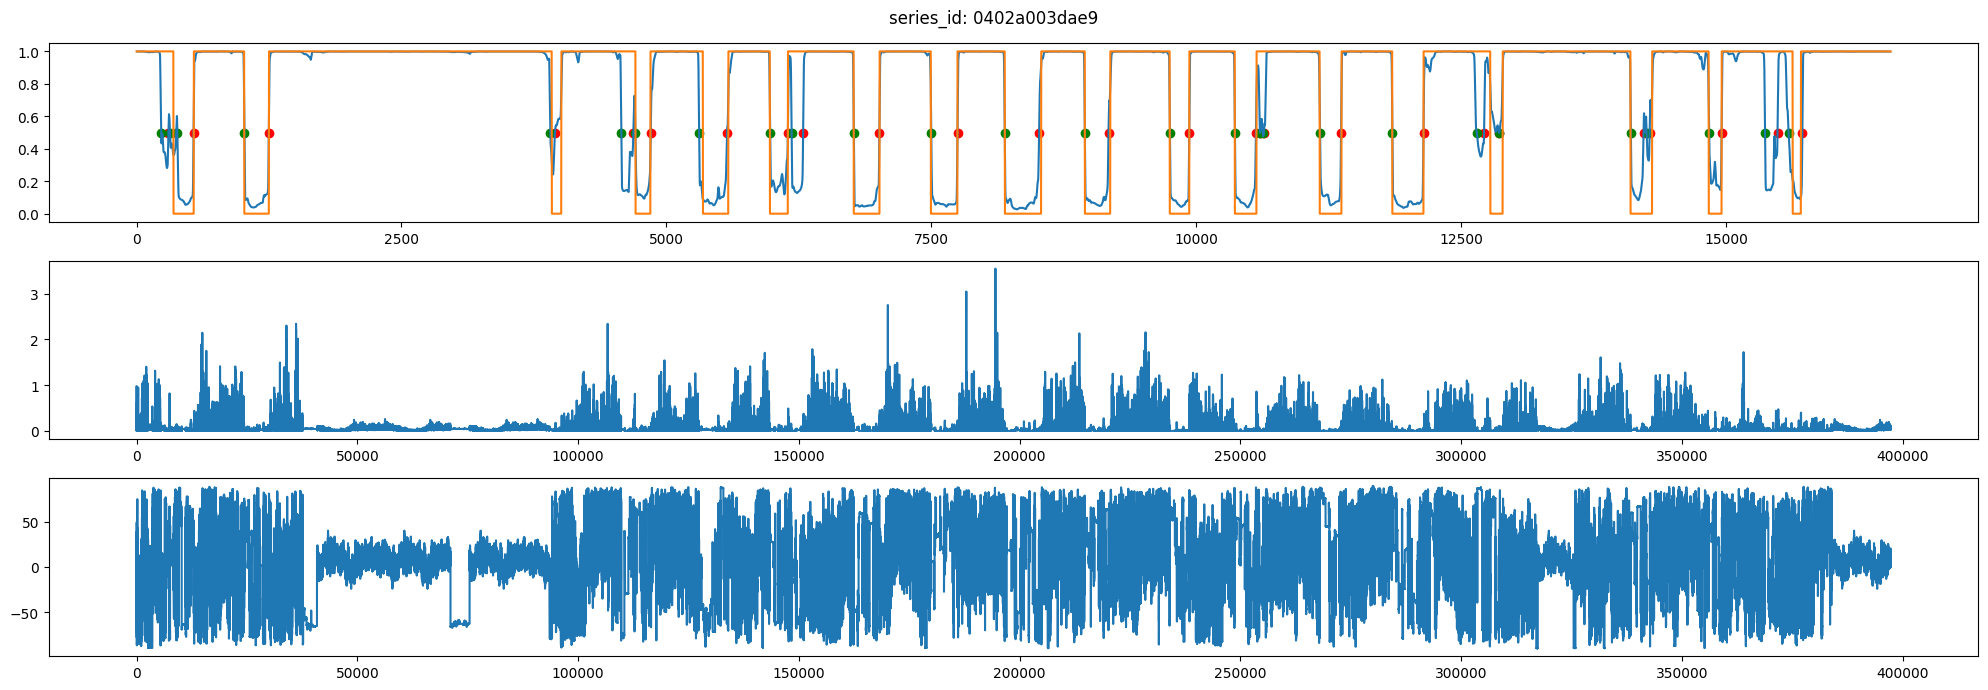

  1%|          | 3/277 [00:03<05:12,  1.14s/it]

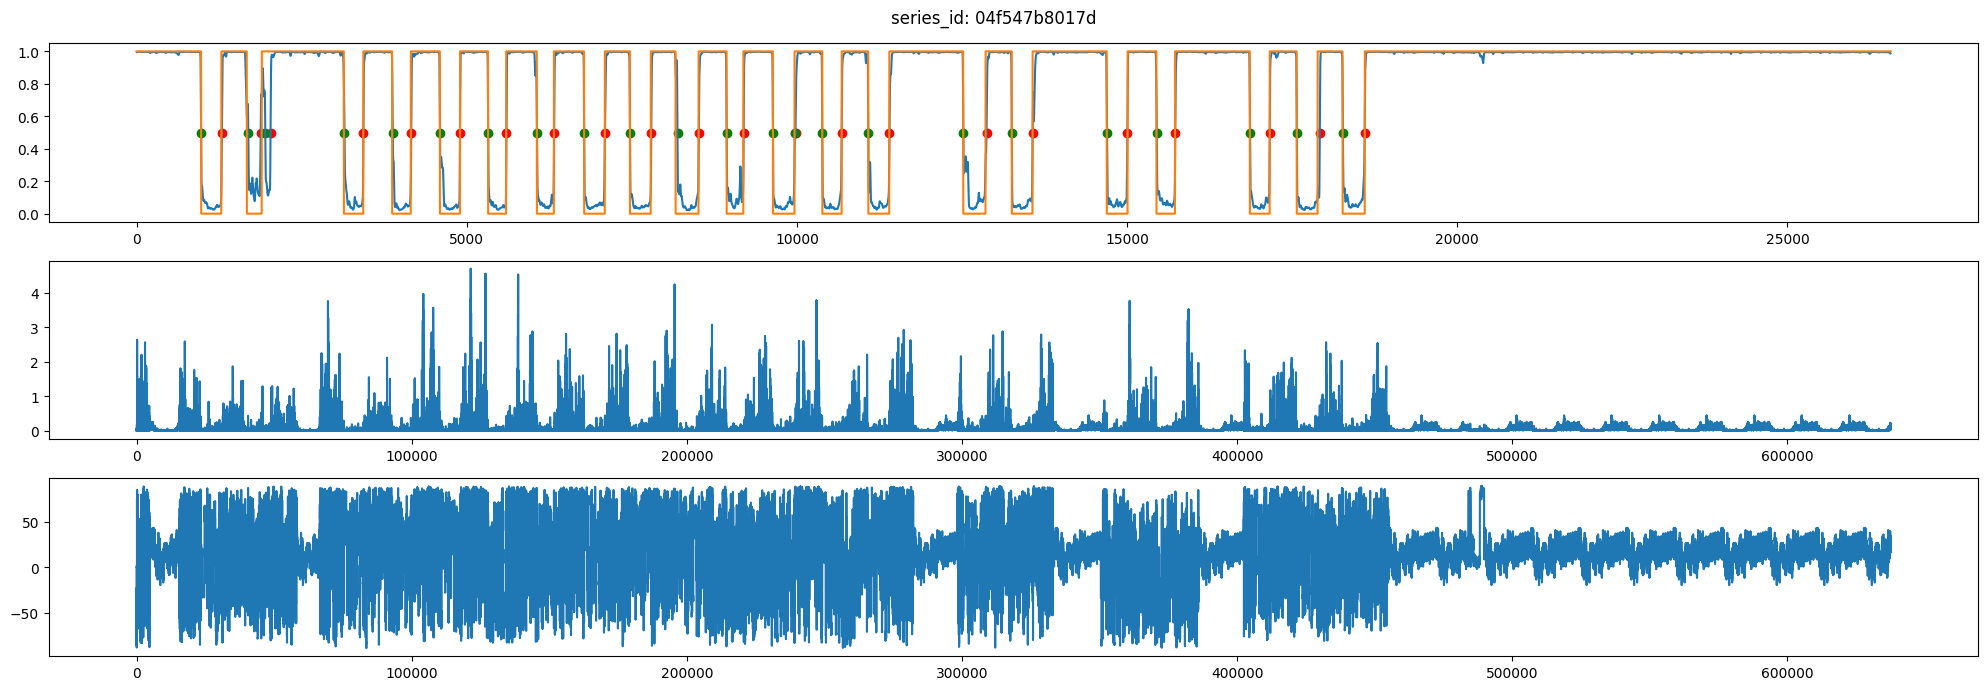

100%|██████████| 277/277 [00:49<00:00,  5.55it/s]


,series_id,step,event,score
0,038441c925bb,10871,wakeup,1
1,038441c925bb,23543,wakeup,1
2,038441c925bb,27503,wakeup,1
3,038441c925bb,44303,wakeup,1
4,038441c925bb,62879,wakeup,1


In [14]:
dfs = []
oofs = []
for series_id, df in tqdm(train.groupby("series_id")):
    df = df.reset_index(drop=True)
    df["raw_oof"] = df["oof"]
    df["oof"] = df["raw_oof"].rolling(12, center=True).mean()
    oofs.append(df)
    wakeup_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] < 0.5 and df["oof"][i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] > 0.5 and df["oof"][i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = sub["step"].astype(int)
        dfs.append(sub)

    if len(dfs) < 5:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(df["oof"])
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

train = pd.concat(oofs)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)
sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.4407


event   tolerance
onset   12           0.013278
        36           0.111355
        60           0.259925
        90           0.395302
        120          0.509233
        150          0.554915
        180          0.595675
        240          0.631104
        300          0.654040
        360          0.669136
wakeup  12           0.019372
        36           0.127205
        60           0.257104
        90           0.395683
        120          0.481884
        150          0.546161
        180          0.587487
        240          0.634625
        300          0.673074
        360          0.697719
dtype: float64

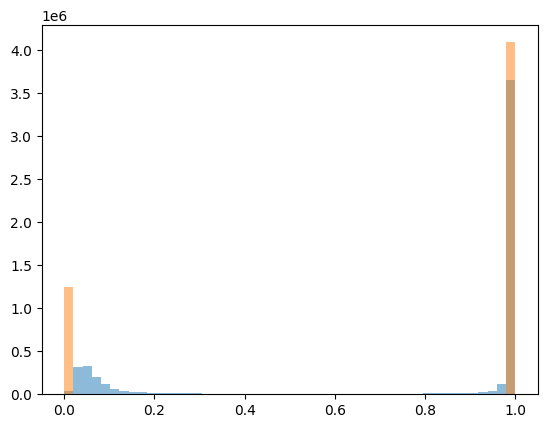

In [15]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()